#  Прогнозирование пика заказов такси

**Заказчик:** Компания «Такси»  
**Исходные данные:** исторические данные о заказах такси в аэропортах за 2018 год  
**Задача:** Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.  

**Решение задачи:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 50.

**План:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Необходимые импорты**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

**Знакомство с данными**

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.head(13)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
df.shape

(26496, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic

True

In [6]:
max_date = df.index.max()
min_date = df.index.min()
print(f'Данные представлены за период c {min_date} по {max_date}')

Данные представлены за период c 2018-03-01 00:00:00 по 2018-08-31 23:50:00


In [7]:
data = df.resample('1H').sum()

In [8]:
def plot(time_series, span):

    rolling_mean = time_series.ewm(span).mean()

    plt.figure(figsize=(15,5))
    plt.title(f'Экспонициально взвешенное, ширина окна = {span} часов')
    plt.plot(rolling_mean, "g", 
             label="Тренд с экспонициальнскользящим средним")


    plt.plot(data[span:], label="Значения", alpha=.42)
    plt.legend(loc="upper left")

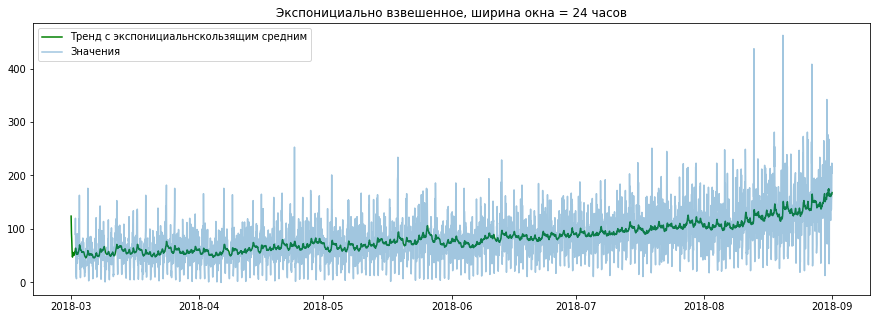

In [9]:
plot(data, 24)

Пропусков нет, индекс монотонно возрастает, отсортирован - можем переходить к дальнейшей обработке данных

**Анализ**

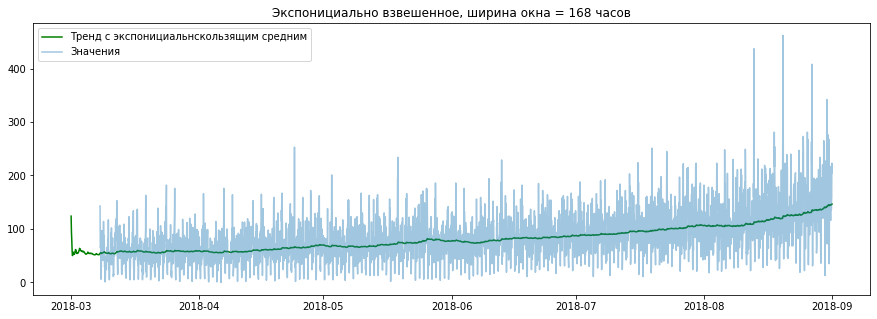

In [10]:
plot(data, 24*7)

Обнаружен тренд повышения количество заказов от марта к августу. Вероятно это связано с покупкой и привлечением всё больших таксопарков, в т.ч. Uber.

In [11]:
print("Средний объём заказов в день:", data['num_orders'].mean())

Средний объём заказов в день: 84.42278079710145


**Разложение временного ряда**

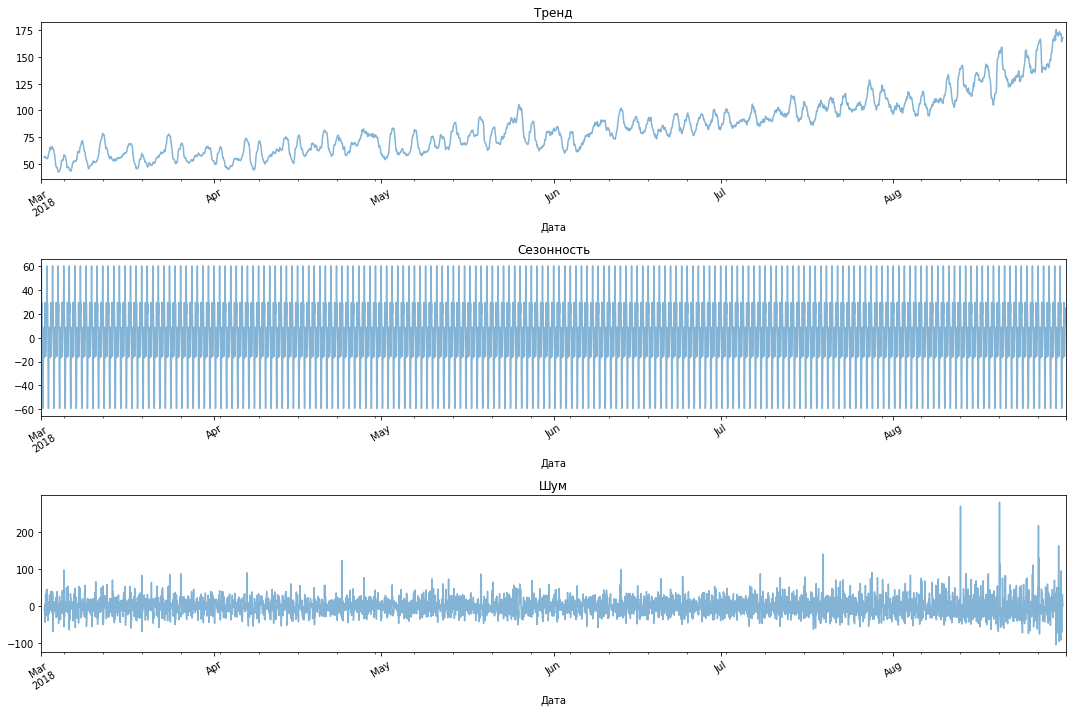

In [12]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), alpha=.55)
plt.title('Тренд')
plt.xticks(rotation=33)
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), alpha=.55) 
plt.title('Сезонность')
plt.xticks(rotation=33)
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), alpha=.55) 
plt.title('Шум')
plt.xticks(rotation=33)
plt.xlabel('Дата')

plt.tight_layout()

<a class="anchor" id="21-bullet"></a> 

**Обучение**

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    for d in ['year', 'month', 'day', 'dayofweek']:
        data[d] = getattr(data.index, d)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 50,100)
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,159.0,157.33
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,156.74
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,156.63


<hr style="border: 2px solid red;" />

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna() 

In [18]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]
X_train, y_train = split_data(train, 'num_orders')
X_test, y_test = split_data(test, 'num_orders')

**Линейная регрессия**

In [19]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
pred  = lr_model.predict(X_train)
rmse = mean_squared_error(pred , train['num_orders'])**0.5
print("RMSE обучающей выборки:", rmse)

RMSE обучающей выборки: 23.356009489864483


**Дерево решений**

Подбор глубины дерева

In [20]:
model = DecisionTreeRegressor(random_state=15)

In [21]:
%%time

param_grid = {"criterion": ["mae"],
              "min_samples_split": [10, 20],
              "max_depth": [2, 6],
              "min_samples_leaf": [20, 40],
              "max_leaf_nodes": [5, 20],
              }

## Comment in order to publish in kaggle.

grid_cv_dtm = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

grid_cv_dtm.fit(X_train, y_train)

CPU times: user 31.4 s, sys: 49.2 ms, total: 31.4 s
Wall time: 31.6 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=15),
             param_grid={'criterion': ['mae'], 'max_depth': [2, 6],
                         'max_leaf_nodes': [5, 20],
                         'min_samples_leaf': [20, 40],
                         'min_samples_split': [10, 20]},
             scoring='neg_mean_squared_error')

In [22]:
grid_cv_dtm.best_params_

{'criterion': 'mae',
 'max_depth': 6,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 20,
 'min_samples_split': 10}

In [23]:
model = grid_cv_dtm.best_estimator_
model.fit(X_train, y_train)
pred  = model.predict(X_train)
rmse = mean_squared_error(pred, y_train)**0.5
print(rmse)

25.228810938962386


**Catboost**

In [24]:
%%time

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, 
                              verbose=100,  random_seed=15)
cat_model.fit(X_train, y_train)
pred2  = cat_model.predict(X_train)
rmse = mean_squared_error(pred2, y_train)**0.5
print("RMSE обучающей выборки:", rmse)

0:	learn: 36.7723636	total: 63.1ms	remaining: 1m 3s
100:	learn: 19.3471631	total: 1.19s	remaining: 10.6s
200:	learn: 15.6878839	total: 2.32s	remaining: 9.22s
300:	learn: 13.3471743	total: 3.5s	remaining: 8.12s
400:	learn: 11.5727301	total: 4.65s	remaining: 6.94s
500:	learn: 10.0429401	total: 5.79s	remaining: 5.77s
600:	learn: 8.8594396	total: 6.94s	remaining: 4.61s
700:	learn: 7.7372276	total: 8.11s	remaining: 3.46s
800:	learn: 6.8095181	total: 9.34s	remaining: 2.32s
900:	learn: 5.9822317	total: 10.5s	remaining: 1.16s
999:	learn: 5.2640564	total: 11.7s	remaining: 0us
RMSE обучающей выборки: 5.264056424913615
CPU times: user 11.7 s, sys: 186 ms, total: 11.9 s
Wall time: 12.9 s


Catboost показал лучшие результаты на обучающей выборке. Проверим на тестовой.

**Тестирование**

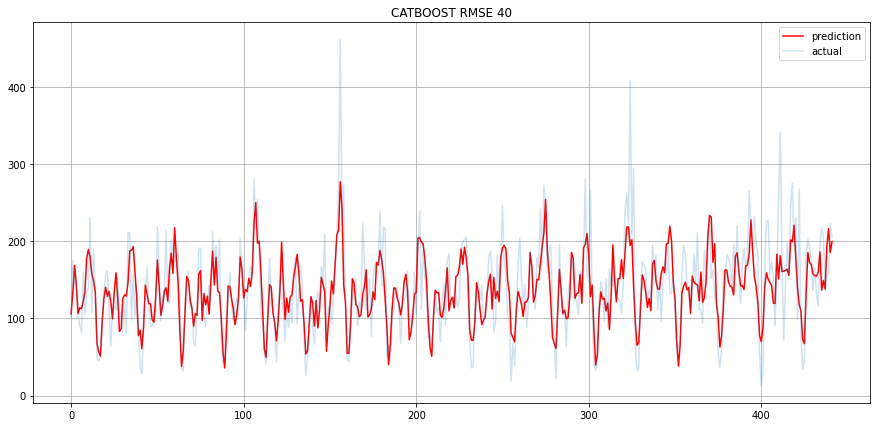

In [25]:
prediction = cat_model.predict(X_test)
rmse_cat = mean_squared_error(prediction, y_test)**0.5
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual", alpha=.21)
plt.legend(loc="best")
plt.title(f"CATBOOST RMSE {round(rmse_cat)}")
plt.grid(True)

**Тест на адекватность модели**

In [26]:
train_chk, test_chk = train_test_split(data, shuffle=False, test_size=0.1)
train_chk = train_chk.dropna()


pred_previous = test_chk.shift(periods=1, fill_value=train_chk['num_orders'].iloc[-1])
prev_rmse = mean_squared_error(test_chk, pred_previous)**0.5
print("Прогнозирование предыдущим значением ряда, RMSE:", 
      round(prev_rmse))

Прогнозирование предыдущим значением ряда, RMSE: 57


**Вывод**

В рамках задачи было протестировано две модели.   
Рекомендация заказчику - модель на основе Catboost, которая показала на тестовой выборке метрику RMSE менее 39.  
Также модель прошла тест на адекватность.